In [1]:
from scipy import signal
import numpy as np
import matplotlib.pylab as plt
from obspy.clients.fdsn import Client
from obspy import UTCDateTime, read

Using the ***Fourier transformation*** to transform a signal from the time domain into the frequency domain.


##### need to add

## Estimating time series

Text(0, 0.5, 'Amplitude')

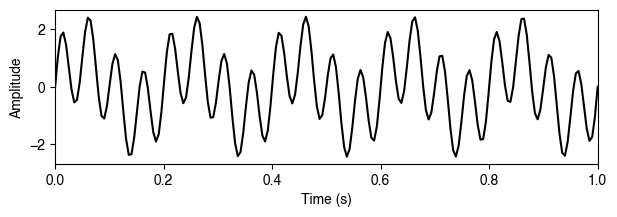

In [14]:
fs = 200  # sampling rate 
t = np.linspace(0, 1, fs)  # time
freq1 = 5 
freq2 = 20 

# 時間域訊號
signal = np.sin(2 * np.pi * freq1 * t) + 1.5 * np.sin(2 * np.pi * freq2 * t)

plt.figure(figsize=(7,2))
plt.plot(t, signal, 'k')
plt.xlim(0,1)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

## Spectrum (頻譜)
Visualizing the distribution of a signal's amplitude or power across its frequency components.

* The `sampling theorem` states that at least 2 samples per period are needed to correctly reproduce the highest frequency of a signal. This is the definition of the **Nyquist frequency**: $f_{Ny}=\frac{1}{2\Delta t}= \frac{\Delta f}{2}$ where $\Delta t$ is sampling interval and $\Delta f$ is sampling frequency.

Text(0.5, 1.0, 'Spectrum')

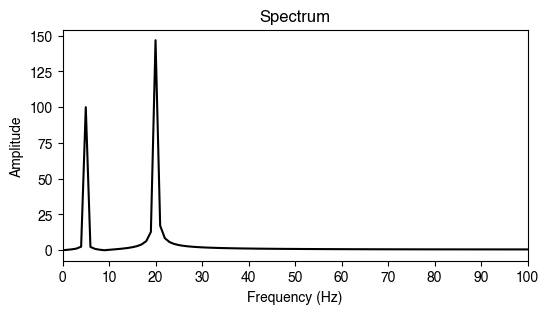

In [16]:
fNy = fs/ 2 
npts = len(t)

spec = np.fft.rfft(signal)
freq = np.linspace(0, fNy, npts // 2 + 1)

plt.figure(figsize=(6,3))
plt.plot(freq, abs(spec), 'k')
plt.xlim(0, fNy)
plt.xticks(range(0, int(fNy+1), 10))
plt.ylabel('Amplitude')
plt.xlabel('Frequency (Hz)')
plt.title('Spectrum')

### Spectrum of seismic waveform

In [4]:
st = read('GR.WET..BHZ.20110311T054623.mseed')

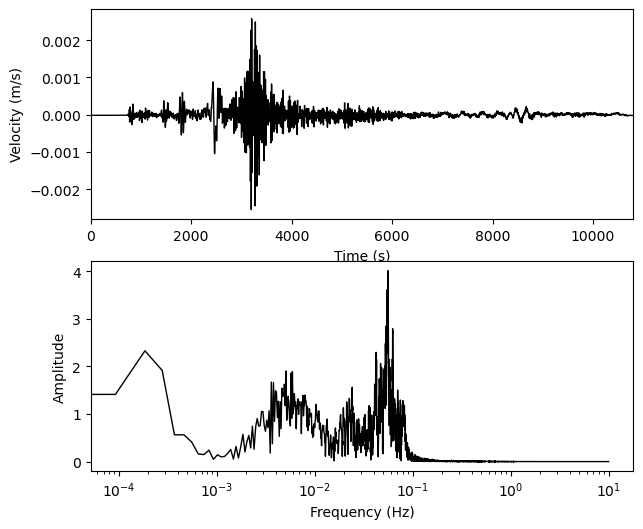

In [5]:
fNy = st[0].stats.sampling_rate / 2
npts = st[0].stats.npts
freq = np.linspace(0, fNy, npts // 2 + 1)

Ospec = np.fft.rfft(st[0].data)

fig, ax = plt.subplots(2,1, figsize=(7,6))
ax[0].plot(st[0].times(), st[0].data, 'k', lw=1)
ax[0].set_xlim(0, 3*60*60)
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Velocity (m/s)')

ax[1].plot(freq, abs(Ospec), 'k', lw=1)
ax[1].set_ylabel('Amplitude')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_xscale('log')

## Spectrogram (時頻圖)

Visualizing the **amplitude change (color)** of a nonstationary signal’s **frequency (y-axis)** content over **time (x-axis)**

In [7]:
from matplotlib import cm
import matplotlib.mlab as mlab
from obspy.signal.util import next_pow_2

In [22]:
length = 1024
spect, f, t = mlab.specgram(st[0].data, NFFT=length, Fs=st[0].stats.sampling_rate,
                            noverlap=int(length*0.9), pad_to=next_pow_2(length) * 4)
   
data = 10* np.log10(np.abs(spect[1:,:])) # convert into dB
f = f[1:]


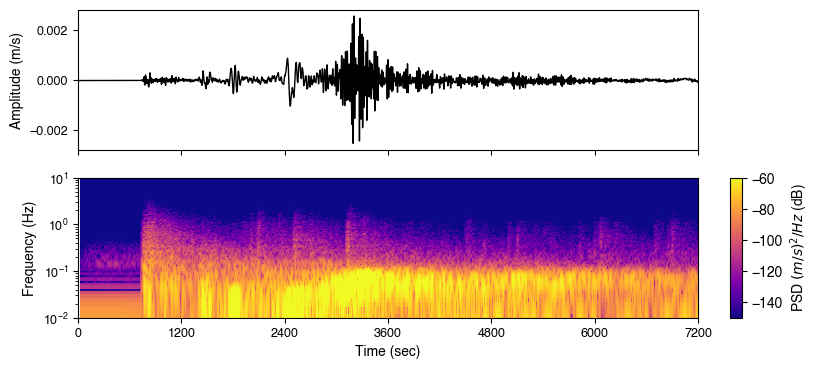

In [25]:
fig, ax = plt.subplots(2,1, figsize=(8, 4), sharex=True)
plt.rcParams["font.family"] = "Helvetica"   

ax[0].plot(st[0].times(), st[0].data, 'k', lw=1)
ax[0].set_xlim(0, 2*3600)
ax[0].set_xticks(range(0, 2*3600+1,1200))
ax[0].set_ylabel('Amplitude (m/s)', fontsize=10)
ax[0].tick_params(axis='both', labelsize=9)

im1 = ax[1].pcolormesh(t, f, data, 
                 vmin=-150, vmax=-60, cmap='plasma', 
                 rasterized=True)
ax[1].set_ylabel('Frequency (Hz)', fontsize=10)
ax[1].set_xlabel('Time (sec)' , fontsize=10)
ax[1].set_ylim(10**-2, 10)
ax[1].set_yscale('log')
ax[1].tick_params(axis='both', labelsize=9)

rect = [0.94, 0.11, 0.015, 0.35]
cbar_ax = fig.add_axes(rect)
plt.colorbar(im1, cax=cbar_ax, label = 'PSD $(m/s)^2/Hz$ (dB)')


## Filtering seismic waveform

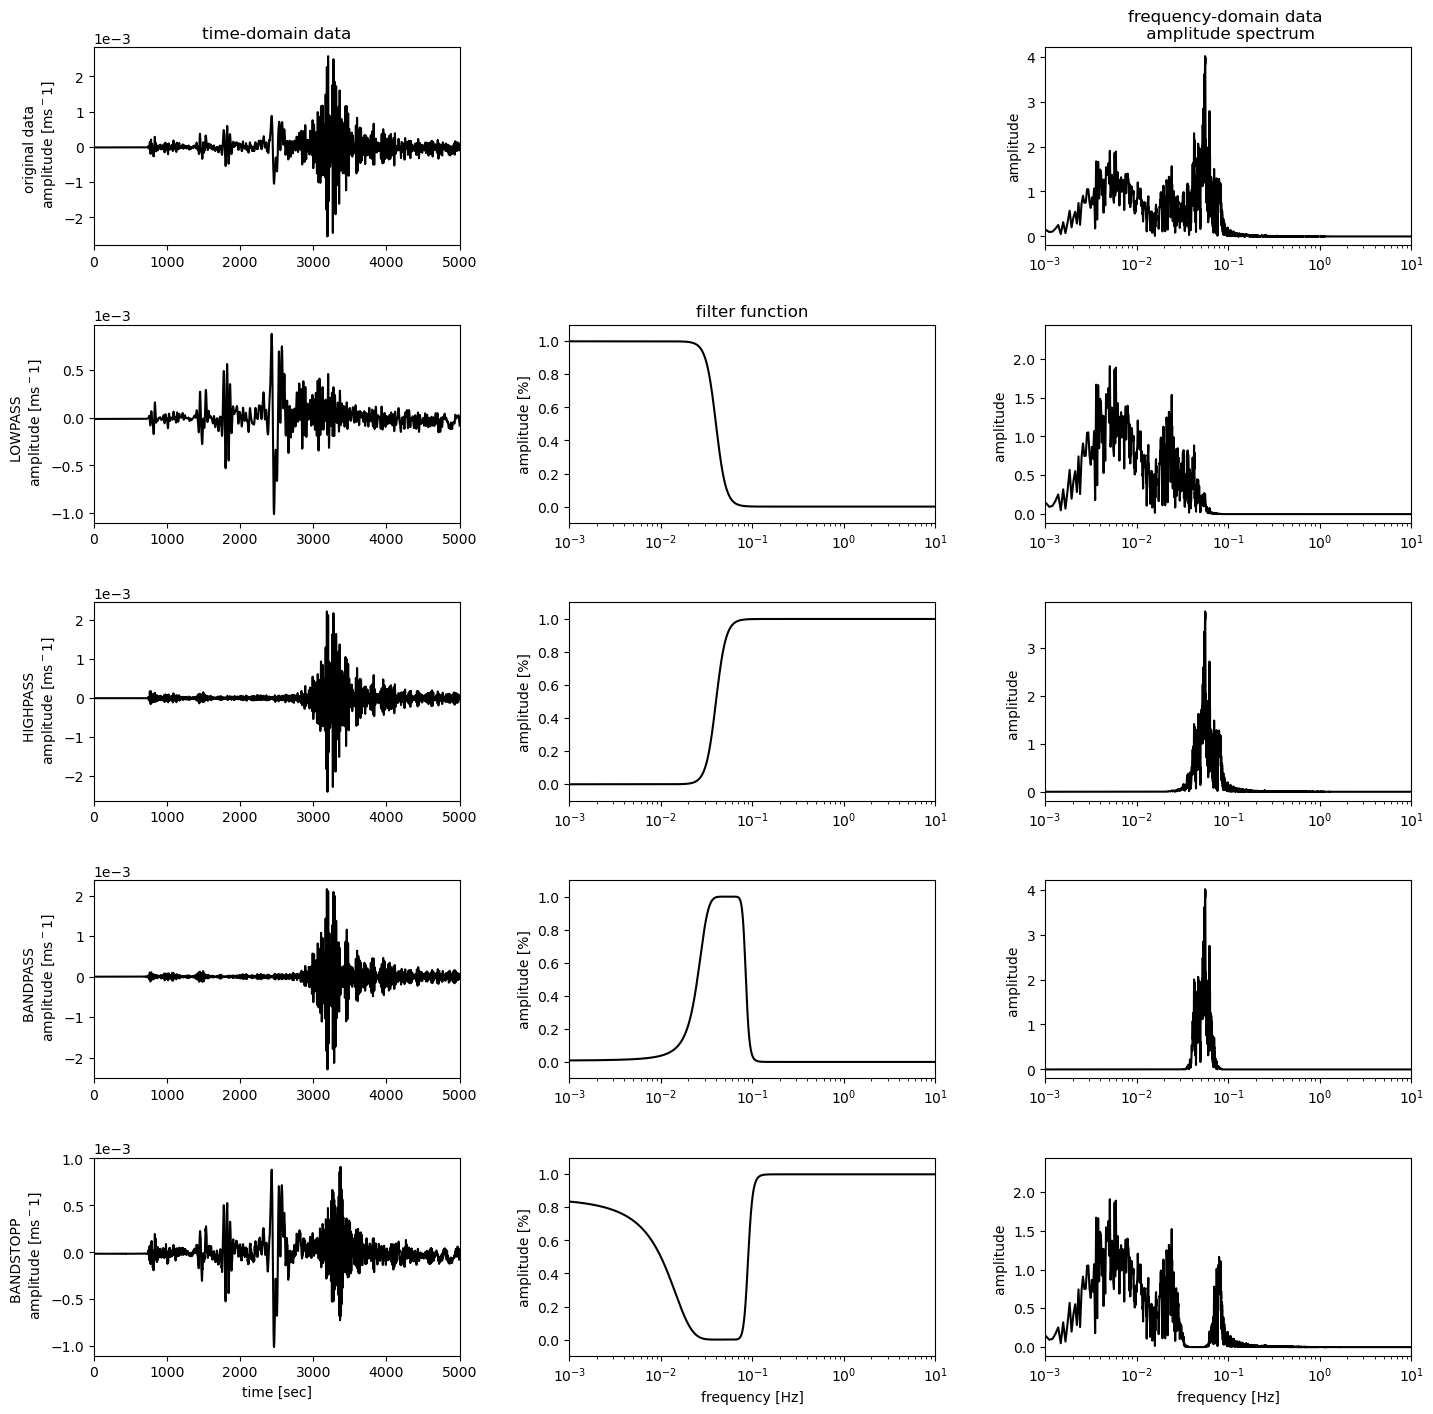

In [6]:
# Cell 2 - filter types
npts = st[0].stats.npts                   # number of samples in the trace
dt = st[0].stats.delta                    # sample interval
fNy = 1. / (2. * dt)                      # Nyquist frequency
time = np.arange(0, npts) * dt            # time axis for plotting
freq = np.linspace(0, fNy, npts // 2 + 1) # frequency axis for plotting
corners = 4                               # order of filter

# several filter frequencies for the different filter types
f0 = 0.04
fmin1 = 0.04
fmax1 = 0.07
fmin2 = 0.03
fmax2 = 0.07

# filter functions
LP = 1 / ( 1 + (freq / f0) ** (2 * corners))
HP = 1 - 1 / (1 + (freq / f0) ** (2 * corners))
wc = fmax1 - fmin1
wb = 0.5 * wc + fmin1
BP = 1/(1 + ((freq - wb) / wc) ** (2 * corners))
wc = fmax2 - fmin2
wb = 0.5 * wc + fmin2
BS = 1 - ( 1 / (1 + ((freq - wb) / wc) ** (2 * corners)))

# filtered traces
stHP = st.copy()
stHP.filter('highpass', freq=f0, corners=corners, zerophase=True)
stLP = st.copy()
stLP.filter('lowpass', freq=f0, corners=corners, zerophase=True)
stBP = st.copy()
stBP.filter('bandpass', freqmin=fmin1, freqmax=fmax1, corners=corners, zerophase=True)
stBS = st.copy()
stBS.filter('bandstop', freqmin=fmin2, freqmax=fmax2, corners=corners, zerophase=True)

# amplitude spectras
Ospec = np.fft.rfft(st[0].data)
LPspec = np.fft.rfft(stLP[0].data)
HPspec = np.fft.rfft(stHP[0].data)
BPspec = np.fft.rfft(stBP[0].data)
BSspec = np.fft.rfft(stBS[0].data)

# ---------------------------------------------------------------
# plot
plt.rcParams['figure.figsize'] = 17, 17
tx1 = 0
tx2 = 5000
fx1 = 0.001
fx2 = 10

fig = plt.figure()

ax1 = fig.add_subplot(5,3,1)
ax1.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(time, st[0].data, 'k')
plt.xlim(tx1, tx2)
plt.title('time-domain data')
plt.ylabel('original data \n amplitude [ms$^-1$]')

ax3 = fig.add_subplot(5,3,3)
plt.plot(freq, abs(Ospec), 'k')
plt.title('frequency-domain data \n amplitude spectrum')
plt.ylabel('amplitude')
plt.xscale('log')
plt.xlim(fx1,fx2)

ax4 = fig.add_subplot(5,3,4)
ax4.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(time, stLP[0].data, 'k')
plt.xlim(tx1, tx2)
plt.ylabel('LOWPASS  \n amplitude [ms$^-1$]')

ax5 = fig.add_subplot(5,3,5)
plt.plot(freq, LP, 'k', linewidth=1.5)
plt.xscale('log')
plt.xlim(fx1, fx2)
plt.ylim(-0.1,1.1)
plt.title('filter function')
plt.ylabel('amplitude [%]')

ax6 = fig.add_subplot(5,3,6)
plt.plot(freq, abs(LPspec), 'k')
plt.ylabel('amplitude ')
plt.xscale('log')
plt.xlim(fx1,fx2)

ax7 = fig.add_subplot(5,3,7)
ax7.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(time, stHP[0].data, 'k')
plt.xlim(tx1, tx2)
plt.ylabel('HIGHPASS  \n amplitude [ms$^-1$]')

ax8 = fig.add_subplot(5,3,8)
plt.plot(freq, HP, 'k', linewidth=1.5)
plt.xscale('log')
plt.xlim(fx1,fx2)
plt.ylim(-0.1,1.1)
plt.ylabel('amplitude [%]')

ax9 = fig.add_subplot(5,3,9)
plt.plot(freq, abs(HPspec), 'k')
plt.ylabel('amplitude ')
plt.xscale('log')
plt.xlim(fx1,fx2)

ax10 = fig.add_subplot(5,3,10)
ax10.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(time, stBP[0].data, 'k')
plt.xlim(tx1, tx2)
plt.ylabel('BANDPASS  \n amplitude [ms$^-1$]')

ax11 = fig.add_subplot(5,3,11)
plt.plot(freq, BP, 'k', linewidth=1.5)
plt.xscale('log')
plt.xlim(fx1, fx2)
plt.ylim(-0.1,1.1)

plt.ylabel('amplitude [%]')

ax12 = fig.add_subplot(5,3,12)
plt.plot(freq, abs(BPspec), 'k')
plt.ylabel('amplitude ')
plt.xscale('log')
plt.xlim(fx1,fx2)

ax13 = fig.add_subplot(5,3,13)
ax13.ticklabel_format(style='sci', axis='y', scilimits=(-1,1))
plt.plot(time, stBS[0].data, 'k')
plt.xlim(tx1, tx2)
plt.xlabel('time [sec]')
plt.ylabel('BANDSTOPP \n amplitude [ms$^-1$]')

ax14 = fig.add_subplot(5,3,14)
plt.plot(freq, BS, 'k', linewidth=1.5)
plt.xscale('log')
plt.xlim(fx1, fx2)
plt.ylim(-0.1,1.1)
plt.ylabel('amplitude [%]')
plt.xlabel('frequency [Hz]')

ax15 = fig.add_subplot(5,3,15)
plt.plot(freq, abs(BSspec), 'k')
plt.xlabel('frequency [Hz]')
plt.ylabel('amplitude ')
plt.xscale('log')
plt.xlim(fx1, fx2)

plt.subplots_adjust(wspace=0.3, hspace=0.4)

### `corners` and `zerophase` effects of [filter](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.filter.html)

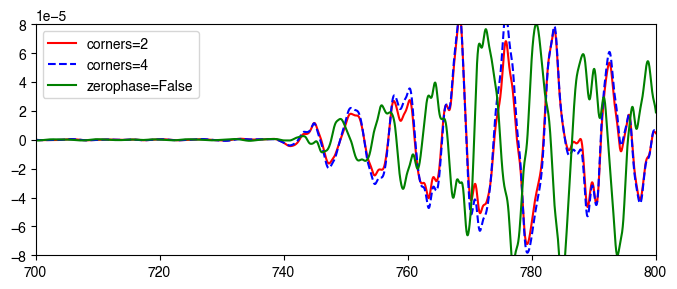

In [67]:
plt.figure(figsize=(8,3))

# plt.plot(st[0].times(), st[0].data, 'k', label='Origin')

stBP = st.copy()
stBP.filter('bandpass', freqmin=0.1, freqmax=1, corners=2, zerophase=True)
plt.plot(stBP[0].times(), stBP[0].data, 'r', label='corners=2')

stBP = st.copy()
stBP.filter('bandpass', freqmin=0.1, freqmax=1, corners=4, zerophase=True)
plt.plot(stBP[0].times(), stBP[0].data, 'b--', label='corners=4')

stBP = st.copy()
stBP.filter('bandpass', freqmin=0.1, freqmax=1, corners=4, zerophase=False)
plt.plot(stBP[0].times(), stBP[0].data, 'g', label='zerophase=False')

plt.xlim(700,800)
plt.ylim(-8*10**-5, 8*10**-5)
plt.legend()

## Calculating Signal-Noise Ratio (SNR)
$SNR = \frac{S_{rms}}{N_{rms}}$, where $S_{rms}$ and $N_{rms}$ are root mean square of signal(**S**) and noise (**N**), respectively.

Text(0.5, 0, 'Time after origins (s)')

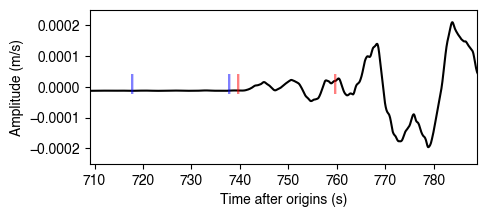

In [11]:
P_arr = 739.030
plt.figure(figsize=(5,2))
plt.plot(st[0].times(), st[0].data, 'k')

# signal
plt.text(x=P_arr, y=0, s='|', color='red', fontsize=20, va='center', alpha=0.5)
plt.text(x=P_arr+20, y=0, s='|', color='red', fontsize=20, va='center', alpha=0.5)

# noise
plt.text(x=P_arr-2, y=0, s='|', color='blue', fontsize=20, va='center', alpha=0.5)
plt.text(x=P_arr-22, y=0, s='|', color='blue', fontsize=20, va='center', alpha=0.5)

plt.xlim(P_arr-30, P_arr+50)
plt.ylim(-2.5*10**-4, 2.5*10**-4)

plt.ylabel('Amplitude (m/s)')
plt.xlabel('Time after origins (s)')

In [28]:
st_bp = st.copy()[0]
st_bp = st_bp.filter('bandpass', freqmin=0.01, freqmax=1, corners=4, zerophase=True)

st_sig = st_bp.copy()
st_sig = st_sig.slice(starttime=st_sig.stats.starttime+P_arr, endtime= st_sig.stats.starttime+P_arr+20)
st_sig_rms = np.sqrt(np.mean(st_sig.data**2))
print(st_sig_rms)

st_noise = st_bp.copy()
st_noise = st_noise.slice(starttime=st_noise.stats.starttime+P_arr-22, endtime= st_noise.stats.starttime+P_arr-2)
st_noise_rms = np.sqrt(np.mean(st_noise.data**2))
print(st_noise_rms)

SNR = st_sig_rms/ st_noise_rms
print(SNR)

1.864236262053875e-05
5.131264142970929e-06
3.633093542080857


##### References:
* https://seismo-live.github.io/html/Signal%20Processing/fourier_transform_solution_wrapper.html
* https://hackmd.io/@sysprog/fourier-transform
* https://github.com/sceylan/Ceylan_etal_2020_Supplement/blob/v0.0/wind.py

#### Accessing waveform in this tutorial

In [ ]:
client = Client("IRIS")
t1 = UTCDateTime("2011-03-11T05:46:23.000")
cata = client.get_events(starttime=t1, endtime=t1 + 60, minmagnitude=7)
evttime = cata[0].origins[0].time


client = Client("BGR")
inv = client.get_stations(network = "GR", station="WET", starttime=evttime, endtime=evttime + 3 * 60 * 60)

st = client.get_waveforms("GR", "WET", "", "BHZ", evttime, evttime + 3 * 60 * 60, 
                          attach_response = True)

st.remove_response(output="VEL")
st.detrend('linear')
st.detrend('demean')

st.write('GR.WET..BHZ.20110311T054623.mseed', format='mseed')

In [ ]:
from obspy.geodetics.base import gps2dist_azimuth, kilometers2degrees
from obspy.taup import TauPyModel
model = TauPyModel(model="iasp91")

In [ ]:
dist, az, baz = gps2dist_azimuth(cata[0].origins[0].latitude, #source lat
                                 cata[0].origins[0].longitude, # source lon
                                 inv[0][0].latitude,  # station lat
                                 inv[0][0].longitude)  # station lon

deg = kilometers2degrees(dist/1000)

print(deg)

In [ ]:
arrivals = model.get_travel_times(source_depth_in_km=cata[0].origins[0].depth/1000,
                                  distance_in_degree=deg,
                                  phase_list=['P', 'S', '3.8kmps'])

print(arrivals)